# Clustering U.S. Counties by Climate Risk and Housing Vulnerability

## Problem
Cluster U.S. counties that on their Expected Annual Loss Rate for Buildings for 17 natural disasters. Then, find outliers in each cluster that share the cluster's risk pattern but have significant distance, and determine if they are doubly vulnerable to climate change because of their heightened risk of weather events (floods, heat, fires) and their housing vulnerability (high rent burden, low vacancy, poor infrastructure). The goal is to target investment in underprepared housing in high risk areas in counties that might be overlooked in regional planning efforts that are tailored to counties in clusters that are more homogenous. While FEMA’s National Risk Index provides a useful composite view of county-level risk, its integration of multiple factors into a single score can obscure important nuances. This project will de-aggregate expected building loss rate by hazard type and examine how it interacts with housing-specific vulnerability. 

## Audience
State and local governments and disaster preparedness agencies that would realize value in the form of saved time and decreased uncertainty. With these insights, they could better prepare for climate damage in the most vulnerable counties, saving lives and money in the case of inevitable extreme weather events, by focusing their resources and efforts on places with high risk and low preparedness. 



In [13]:
# Import Dependencies
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from matplotlib.colors import ListedColormap
import census

## Data
The first data set comes from the FEMA National Risk Index, which defines risk as the potential for negative impacts as a result of 18 natural hazards (earthquake, flood, winter weather, hail, etc). The risk equation behind the Risk Index includes three components: a natural hazards component (Expected Annual Loss), a consequence enhancing component (Social Vulnerability), and a consequence reduction component (Community Resilience). The dataset supporting the natural hazards component provides estimates measured in 2022 U.S. dollars. 

For this project, I am only extracting the column "Expected Annual Loss Rate - Building". This rate is designed to reflect the average expected annual percentage loss for the building value within each county, controlled for community size. EAL Rate metrics are calculated as decimals but can be understood as the fraction of a value (whether buildings, people, or agriculture) that could be expected to be lost annually on average. For example, a building EAL Rate of 0.00013 is equivalent to an expectation of $1 out of every $7.7K of building value lost to natural hazards annually on average.

The second data set comes from the U.S. Census American Community Survey 2021 5-Year Estimates, which provides demographic data for each county in the US. The features were selected to capture specifically housing vulnerability, with new variables that are not included in the SVI that is used to calculate FEMA's Risk Index. These features are: Median Year Built, % Units Build Pre-1940, % Overcrowded Units, Median Rent as % of Income, % Renters Spending >50% Income on Rent, % Vacant Units, % Renter Occupied Units, % Mobile Homes, % Units Lacking Plumbing, Total Housing Units.

In [14]:
# Import fema risk index data
data = pd.read_csv('NRI_Table_Counties.csv')

# Keep Expected Annual Loss Rate - Building for Each Hazard
keep_cols = ["STATEABBRV", "STATEFIPS", "COUNTYFIPS", 'STCOFIPS', 'POPULATION','BUILDVALUE','AREA']
alrb_cols = [col for col in data.columns if "_ALRB" in col]
df = data[keep_cols + alrb_cols]

num_rows, num_cols = df.shape
print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_cols}")

Number of rows: 3231
Number of columns: 24


In [15]:
#import census data & create housing features

from census import Census

API_KEY = "a25a6b897f5af035776a6226ae83119d8ca9791b"
c = Census(API_KEY)

variables = {
    "B25035_001E": "median_year_built",
    "B25034_011E": "units_pre1940",
    "B25034_001E": "total_units_pre1940_base",
    "B25014_005E": "renter_over_1_1to1_5",
    "B25014_006E": "renter_over_1_5to2",
    "B25014_007E": "renter_over_2",
    "B25014_011E": "owner_over_1_1to1_5",
    "B25014_012E": "owner_over_1_5to2",
    "B25014_013E": "owner_over_2",
    "B25014_001E": "total_occupied_rooms",
    "B25071_001E": "median_rent_pct_income",
    "B25070_010E": "renters_over_50pct_income",
    "B25070_001E": "total_renters_income_base",
    "B25001_001E": "total_housing_units",
    "B25002_003E": "vacant_units",
    "B25002_001E": "total_units_vacancy_base",
    "B25003_003E": "renter_occupied_units",
    "B25003_001E": "total_occupied_units",
    "B25032_011E": "mobile_homes_owner",
    "B25032_022E": "mobile_homes_renter",
    "B25032_001E": "total_units_mobile_base",
    "B25047_003E": "lacking_plumbing",
    "B25047_001E": "total_units_plumbing_base",
    "B01003_001E": "total_population",
    "B25004_002E" :  "for_rent",
    "B25004_004E" : "for_sale_only",
    "B25004_003E" : "sold_not_occupied",
    "B25004_005E" : "rented_not_occupied"  
}


response = c.acs5.get(
    list(variables.keys()) + ["NAME"],
    {'for': 'county:*', 'in': 'state:*'},
    year=2021
)

housing_data = pd.DataFrame(response)

housing_data = housing_data.rename(columns=variables)

housing_data["state_fips"] = housing_data["state"]
housing_data["county_fips"] = housing_data["county"]
housing_data["fips"] = housing_data["state"] + housing_data["county"]

for col in variables.values():
    housing_data[col] = pd.to_numeric(housing_data[col], errors="coerce")

# % housing units built before 1940
housing_data["pct_units_pre1940"] = (
    housing_data["units_pre1940"] / housing_data["total_units_pre1940_base"] * 100
)

# % occupied housing units that are overcrowded (>1.01 persons per room)
housing_data["overcrowded_total"] = (
    housing_data["renter_over_1_1to1_5"] + housing_data["renter_over_1_5to2"] + housing_data["renter_over_2"] +
    housing_data["owner_over_1_1to1_5"] + housing_data["owner_over_1_5to2"] + housing_data["owner_over_2"]
)
housing_data["pct_overcrowded"] = (
    housing_data["overcrowded_total"] / housing_data["total_occupied_rooms"] * 100
)

# % renters spending >50% income on rent
housing_data["pct_renters_over_50pct_income"] = (
    housing_data["renters_over_50pct_income"] / housing_data["total_renters_income_base"] * 100
)

# % vacant units
housing_data["pct_vacant_units"] = (
    housing_data["vacant_units"] / housing_data["total_units_vacancy_base"] * 100
)

# % renter occupied units of all occupied units
housing_data["pct_renter_occupied"] = (
    housing_data["renter_occupied_units"] / housing_data["total_occupied_units"] * 100
)

# % mobile homes of all housing units
housing_data["mobile_home_units"] = (
    housing_data["mobile_homes_owner"] + housing_data["mobile_homes_renter"]
)
housing_data["pct_mobile_homes"] = (
    housing_data["mobile_home_units"] / housing_data["total_units_mobile_base"] * 100
)

# % housing units lacking plumbing 
housing_data["pct_lacking_plumbing"] = (
    housing_data["lacking_plumbing"] / housing_data["total_units_plumbing_base"] * 100
)

# % available housing
housing_data["for_sale_total"] = (
    housing_data["for_rent"] + housing_data["for_sale_only"] 
)

housing_data["total_housing_base"] = (
    housing_data["for_rent"] + housing_data["for_sale_only"] 
    + housing_data['sold_not_occupied'] + housing_data['rented_not_occupied']
)
housing_data["pct_avail_housing"] = (
    housing_data["for_sale_total"] / housing_data["total_housing_base"] * 100
)


output_columns = [
    "fips", "NAME", "total_population", "median_year_built",
    "pct_units_pre1940", "pct_overcrowded", "median_rent_pct_income",
    "pct_renters_over_50pct_income", "pct_vacant_units",
    "pct_renter_occupied", "pct_mobile_homes", "pct_lacking_plumbing",
      'total_housing_units', "pct_avail_housing"
]
housing = housing_data[output_columns]

num_rows, num_cols = housing.shape
print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_cols}")

Number of rows: 3221
Number of columns: 14


In [16]:
# Merge expected loss rates w/ housing census data
housing.loc[:, "fips"] = housing["fips"].astype(str).str.lstrip("0")
df.loc[:, "STCOFIPS"] = df["STCOFIPS"].astype(str).str.lstrip("0")
full_df = df.merge(housing, how="left", left_on="STCOFIPS", right_on="fips")

/var/folders/vd/kxtbrgs50mx5h4q6mzczwdgc0000gn/T/ipykernel_46114/2759558546.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['1001' '1003' '1005' ... '78010' '78020' '78030']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:, "STCOFIPS"] = df["STCOFIPS"].astype(str).str.lstrip("0")


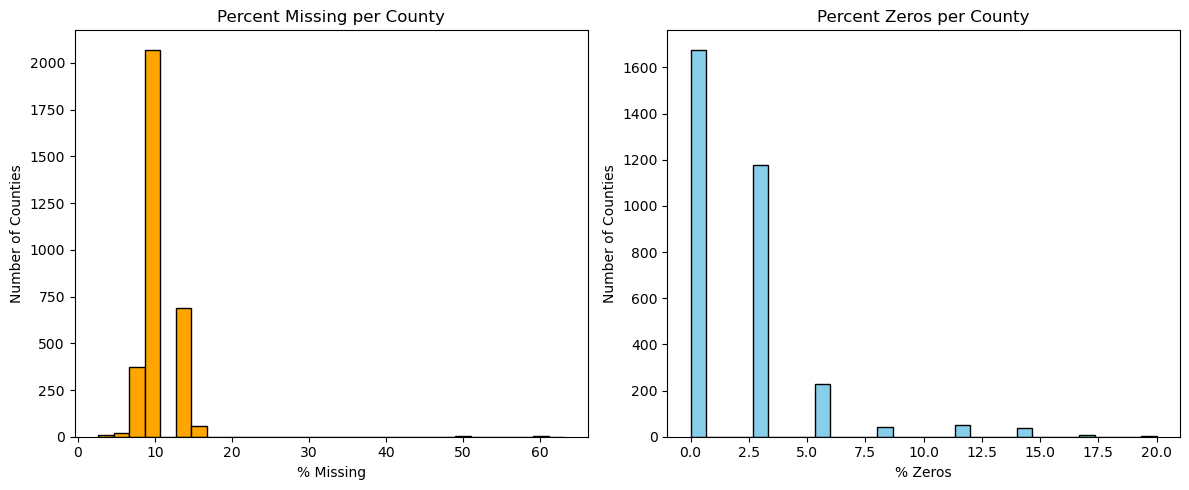

Unique FIPS/counties codes: 3231
Total rows: 3231
Total columns: 40


In [17]:
# Data Checks
import matplotlib.pyplot as plt

# % Missing Values & Zeroes by County

percent_missing = full_df.isnull().mean(axis=1) * 100
full_df["percent_missing"] = percent_missing

numeric_cols = full_df.select_dtypes(include=["number"]).columns
percent_zeros = (full_df[numeric_cols] == 0).mean(axis=1) * 100
full_df["percent_zeros"] = percent_zeros


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(full_df["percent_missing"], bins=30, color='orange', edgecolor='black')
plt.title("Percent Missing per County")
plt.xlabel("% Missing")
plt.ylabel("Number of Counties")

plt.subplot(1, 2, 2)
plt.hist(full_df["percent_zeros"], bins=30, color='skyblue', edgecolor='black')
plt.title("Percent Zeros per County")
plt.xlabel("% Zeros")
plt.ylabel("Number of Counties")

plt.tight_layout()
plt.show()

num_unique_fips = full_df['STCOFIPS'].nunique()
num_rows = full_df.shape[0]
num_cols = full_df.shape[1]

print(f"Unique FIPS/counties codes: {num_unique_fips}")
print(f"Total rows: {num_rows}")
print(f"Total columns: {num_cols}")

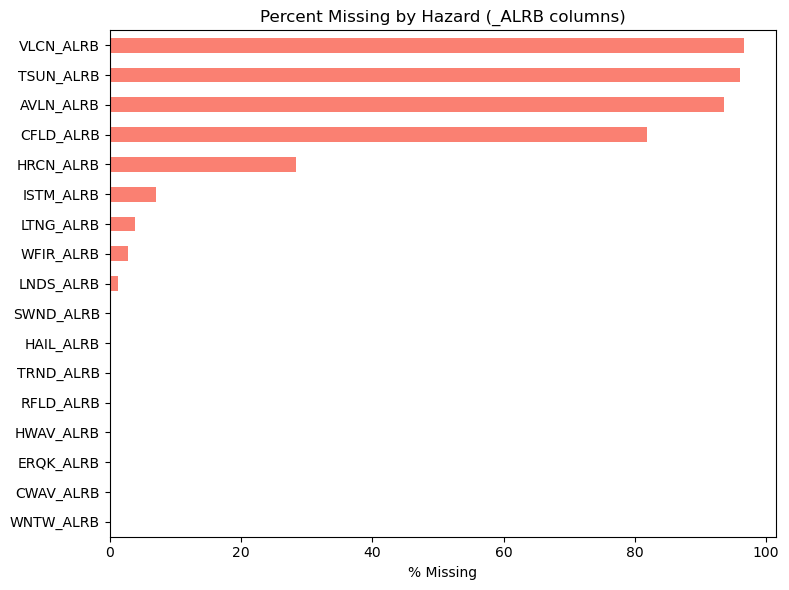

In [18]:
# Missing data by Hazard
hazard_cols = [col for col in full_df.columns if col.endswith("_ALRB")]
missing = full_df[hazard_cols].isnull().mean() * 100
missing.sort_values().plot(kind='barh', figsize=(8, 6), color='salmon')
plt.title("Percent Missing by Hazard (_ALRB columns)")
plt.xlabel("% Missing")
plt.tight_layout()
plt.show()

(full_df.isnull().mean() * 100).sort_values(ascending=False).head(10)

hazard_cols = [col for col in full_df.columns if '_ALRB' in col]
full_df[hazard_cols] = full_df[hazard_cols].fillna(0)

Counties in which the hazard is (historically) impossible have missing data in that cell. The top five hazards with the greatest % of counties with missing data, where that hazard would theoretically never happen, are volcanic activity, tsunami, avalanche, coastal flooding, hurricane, which makes sense because a large portion of the country doesn't have volcanoes, snow covered mountains, and is not by the coast. We are going to put 0 here because it represents zero expected annual loss in these counties. It also appears that generally, most demographic/housing variables do not have a lot of missing data, as the demographic feature with the highest % of missing data is pct_avail_housing which is missing 0.74% of its data. 

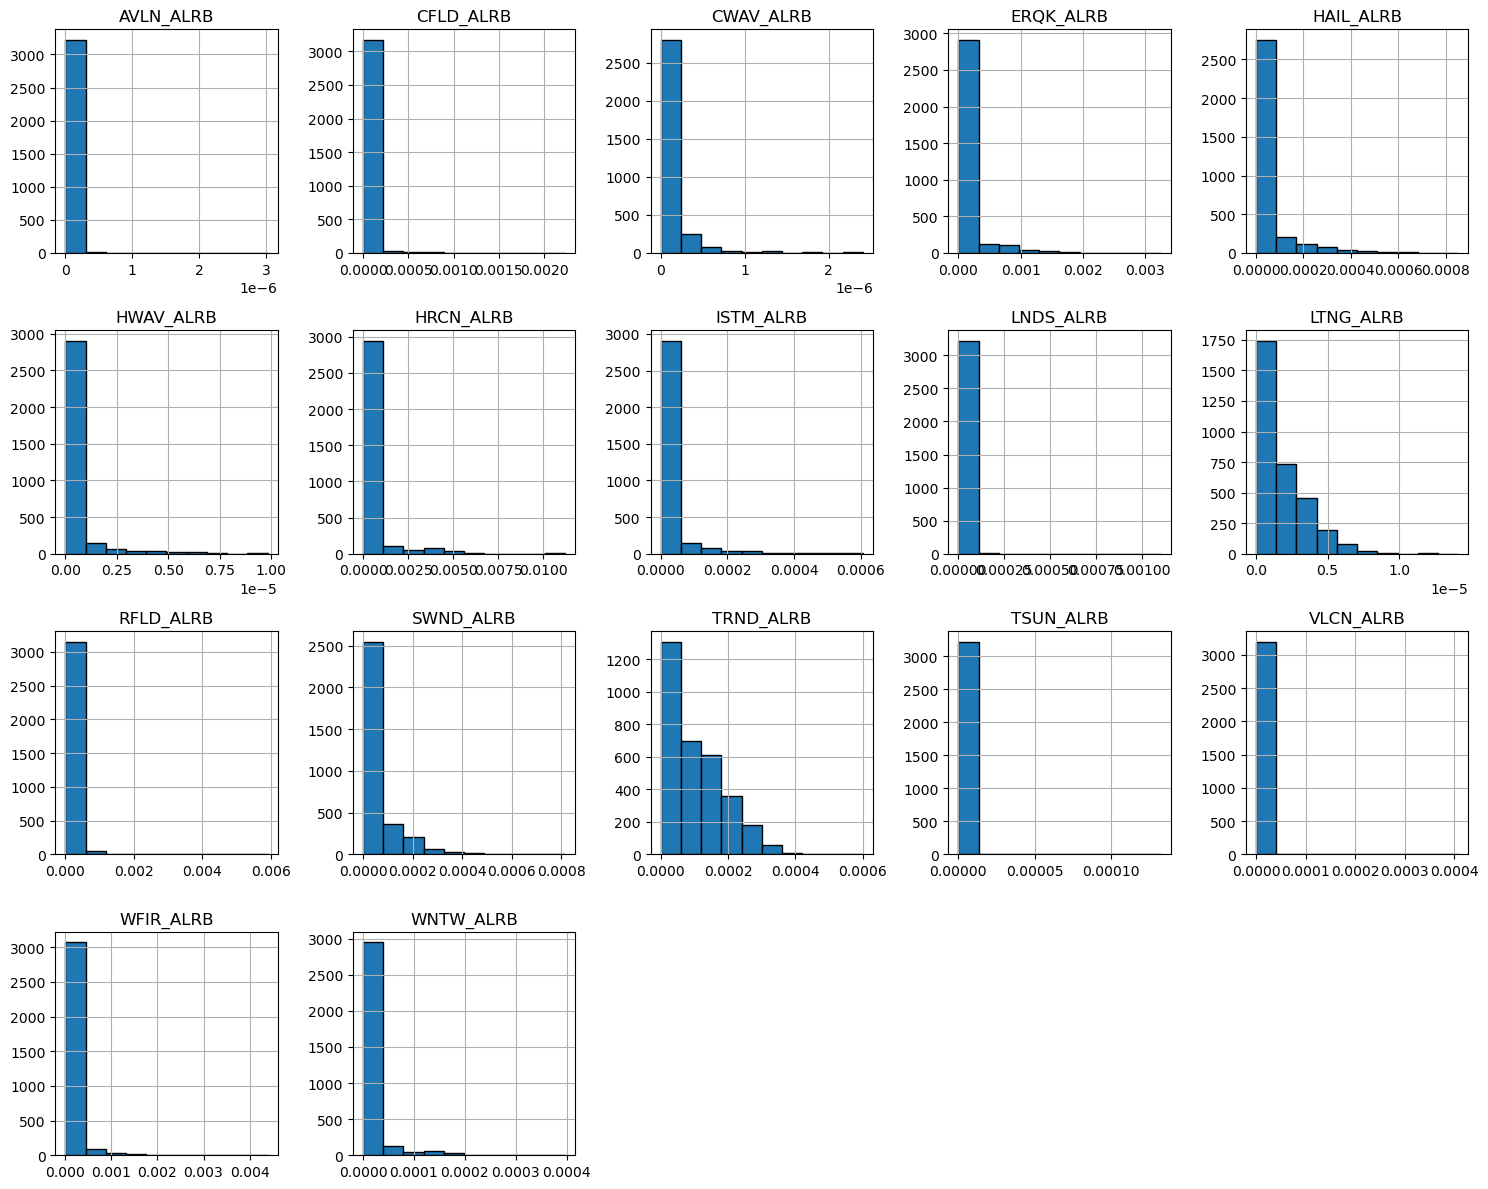

In [19]:
# Check distribution of EAL by Hazard + log transform columns
import numpy as np

alrb_columns = [col for col in full_df.columns if '_ALRB' in col]

n_cols = 5  
n_rows = int(np.ceil(len(alrb_columns) / n_cols))  
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))
axes = axes.flatten()

for i, col in enumerate(alrb_columns):
    axes[i].hist(full_df[col].dropna(), bins=10, edgecolor='black')   
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].grid(True)

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

df_log = full_df[alrb_columns].apply(lambda x: np.log(x + 1))  

full_df[alrb_columns] = df_log

Histograms depict long right tails on all the hazards' expected loss rate distributions, so applying a log transformation will normalize and control the variance. 

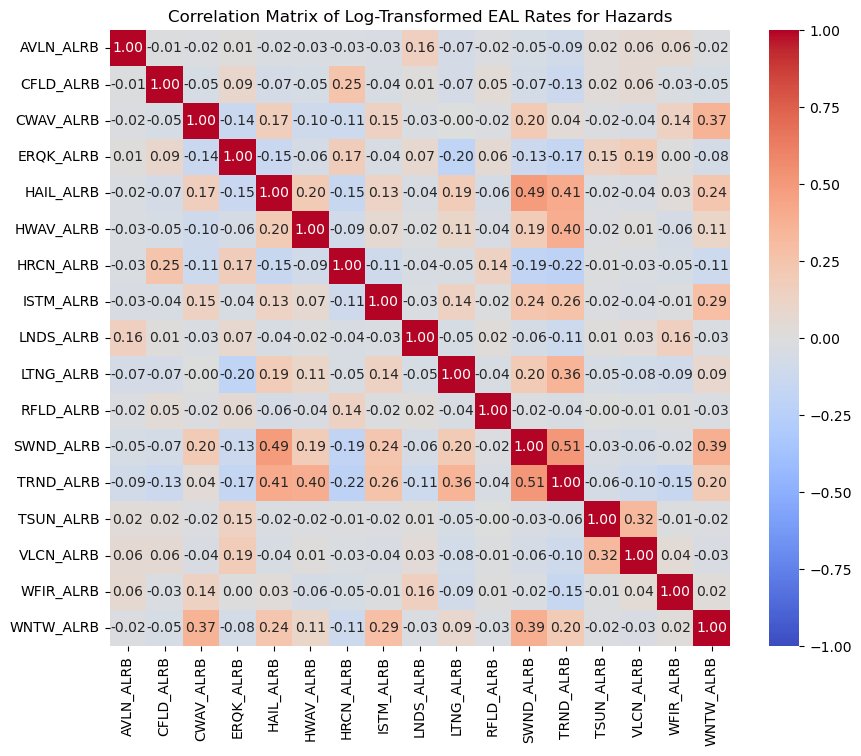

In [20]:
import seaborn as sns
log_corr = df_log.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(log_corr, annot=True, fmt='.2f', cmap='coolwarm', cbar=True, vmin=-1, vmax=1)
plt.title('Correlation Matrix of Log-Transformed EAL Rates for Hazards')
plt.show()

Correlation matrix does not reveal particular collinearity between EAL Building Rates for the different hazards. 

In [21]:
# Check top 5 counties by population
county_pops = full_df.groupby("NAME")["total_population"].sum()
top5_counties = county_pops.nlargest(5)
print("Top 5 Counties by Population:\n", top5_counties)

Top 5 Counties by Population:
 NAME
Los Angeles County, California    10019635.0
Cook County, Illinois              5265398.0
Harris County, Texas               4697957.0
Maricopa County, Arizona           4367186.0
San Diego County, California       3296317.0
Name: total_population, dtype: float64


In [22]:
# Check for any negative values + change to NA
import numpy as np

numeric_cols = full_df.select_dtypes(include='number')
negative_counts = (numeric_cols < 0).sum()
columns_with_negatives = negative_counts[negative_counts > 0]
print("Columns with negative values:\n", columns_with_negatives)

negatives_bool = full_df.select_dtypes(include='number') < 0
negative_cells = negatives_bool[negatives_bool].stack()
negative_locations = negative_cells.index.tolist()

negatives = full_df.select_dtypes(include='number')[negatives_bool]
negative_entries = negatives[negatives < 0].stack()
negative_entries_df = negative_entries.reset_index()
negative_entries_df.columns = ['RowIndex', 'Column', 'Value']
print(negative_entries_df)

cleaned_df = full_df.copy(deep=True)
numeric_cols = cleaned_df.select_dtypes(include='number').columns
cleaned_df[numeric_cols] = cleaned_df[numeric_cols].mask(cleaned_df[numeric_cols] < 0, np.nan)

numeric_cols = cleaned_df.select_dtypes(include='number')
negative_counts = (numeric_cols < 0).sum()
columns_with_negatives = negative_counts[negative_counts > 0]
print("Columns with negative values:\n", columns_with_negatives)

Columns with negative values:
 median_year_built         1
median_rent_pct_income    4
dtype: int64
   RowIndex                  Column        Value
0        84       median_year_built -666666666.0
1      2654  median_rent_pct_income -666666666.0
2      2658  median_rent_pct_income -666666666.0
3      2674  median_rent_pct_income -666666666.0
4      2745  median_rent_pct_income -666666666.0
Columns with negative values:
 Series([], dtype: int64)


In [23]:
# Import Geographic Data for each county & merge on FIPS
import geopandas as gpd

gdf = gpd.read_file("tl_2021_us_county/tl_2021_us_county.shp")
gdf = gdf.to_crs(epsg=4326)

gdf["STCOFIPS"] = gdf["STATEFP"] + gdf["COUNTYFP"]
gdf["lon"] = gdf.centroid.x
gdf["lat"] = gdf.centroid.y
county_centroids = gdf[["STCOFIPS", "lat", "lon"]]

county_centroids.loc[:, "STCOFIPS"] = county_centroids["STCOFIPS"].astype(int).astype(str)

cleaned_df = county_centroids[county_centroids["STCOFIPS"].isin(cleaned_df["STCOFIPS"])].merge(
    cleaned_df, on="STCOFIPS", how="left"
)

/var/folders/vd/kxtbrgs50mx5h4q6mzczwdgc0000gn/T/ipykernel_46114/422641657.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["lon"] = gdf.centroid.x
/var/folders/vd/kxtbrgs50mx5h4q6mzczwdgc0000gn/T/ipykernel_46114/422641657.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["lat"] = gdf.centroid.y


In [24]:
# Remove unnecessary cols
columns_to_remove = ['STATEFIPS', 'COUNTYFIPS', "fips", 'POPULATION','percent_missing','percent_zeros']
cleaned_df = cleaned_df.drop(columns=columns_to_remove)

In [26]:
# Import full data, remove rows with NAs, normalize, create df EAL for 17 hazards only
cleaned_df = cleaned_df.dropna(axis=0)

columns_to_remove = ['STCOFIPS', 'lat', 'NAME','lon', 'STATEABBRV']
X_full = cleaned_df.drop(columns=columns_to_remove)

columns = X_full.columns
scaler = StandardScaler()
X_full_scaled = scaler.fit_transform(X_full)

X_full_scaled_df = pd.DataFrame(X_full_scaled, columns=columns)
X_hazards = X_full_scaled_df.filter(like='_ALRB', axis=1)

## Feature Engineering:
Despite the EAL for the hazards showing low correlation, we will attempt PCA on the counties to reduce collinearity.

k for 90% variance: 14


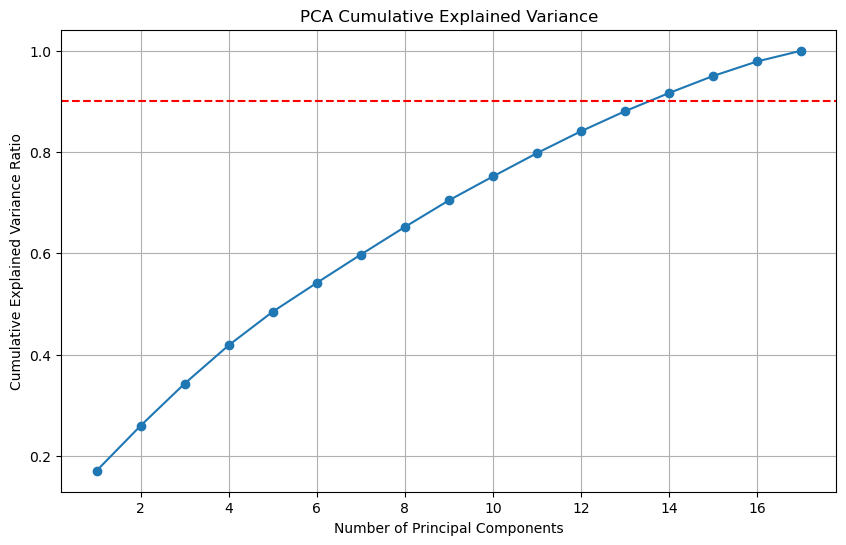

In [27]:
# PCA 
X_hazards = X_hazards.to_numpy()

pca = PCA()
X_pca = pca.fit_transform(scaler.fit_transform(X_hazards))

explained_variance = np.cumsum(pca.explained_variance_ratio_)
k_90 = np.argmax(explained_variance >= 0.9) + 1
print(f'k for 90% variance: {k_90}')

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.axhline(y=0.9, color='r', linestyle='--')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance Ratio")
plt.title("PCA Cumulative Explained Variance")
plt.grid()
plt.show()

k = np.argmax(explained_variance >= 0.9) + 1

Though choosing k=14 components explains 90% of the variance in X, the first component starts very low and doesn't explain much variance on its own. There is potentially an elbow around the 2nd or 3rd component but because it is not obvious and each component is so incremental, we will not use PCA to address collinearity in the features. 

## K-Means Clustering: Determining how many clusters (k) to fit on the county data

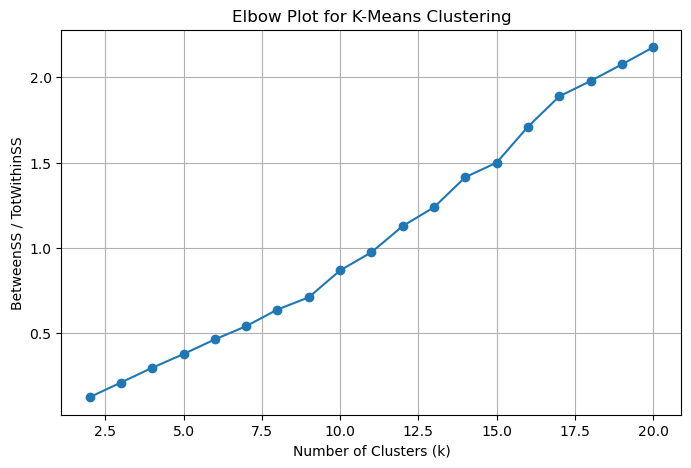

In [28]:
# K Means Elbow Plot
X_scaled = X_hazards
df_mat = X_scaled

n_obs = df_mat.shape[0]

if n_obs >= 2:
    ks = list(range(2, min(20, n_obs) + 1))
    ratios = []

    for k in ks:
        km = KMeans(n_clusters=k, n_init=10, random_state=0)
        km.fit(df_mat)
        withinss = km.inertia_   
        totss = np.var(df_mat, axis=0).sum() * n_obs  
        betweenss = totss - withinss
        ratios.append((betweenss) / withinss)   

    plt.figure(figsize=(8, 5))
    plt.plot(ks, ratios, marker='o')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('BetweenSS / TotWithinSS')
    plt.title('Elbow Plot for K-Means Clustering')
    plt.grid(True)
    plt.show()
else:
    print("Not enough complete counties to run elbow plot.")

There is a slight kink in the elbow plot at k=9 clusters, so we will start there for k-means clustering.

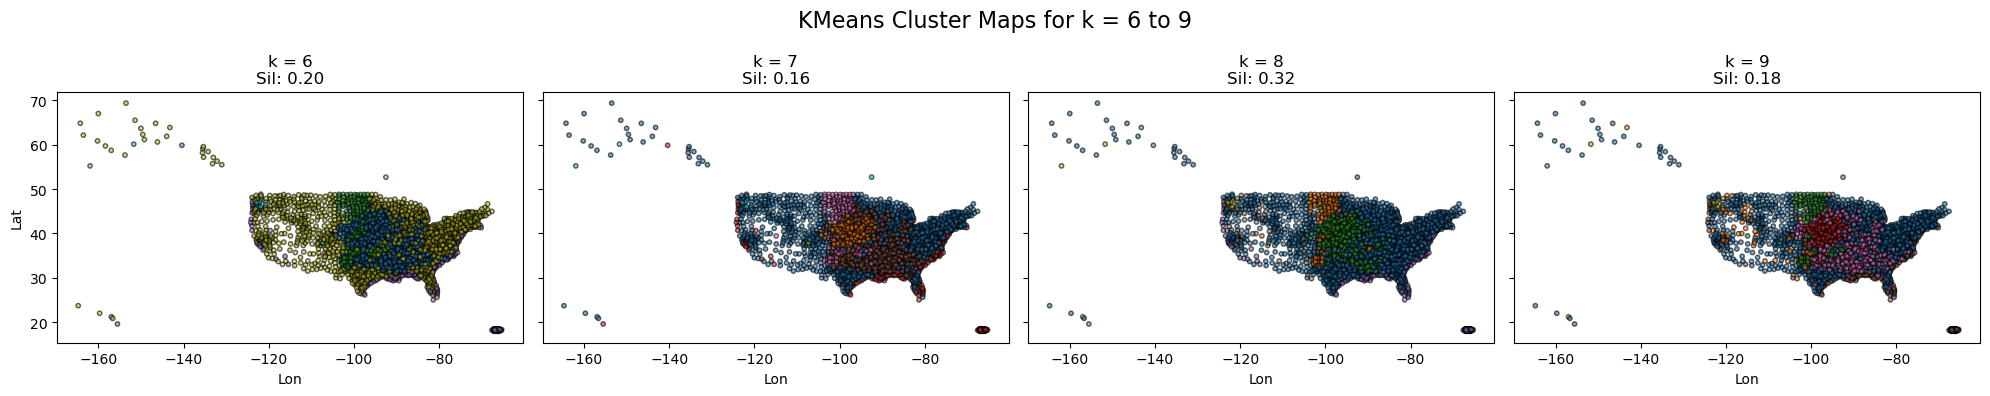

 k  silhouette_score
 6          0.200795
 7          0.155359
 8          0.316292
 9          0.176820


In [29]:
# K-Means Clustering for k=6-9
k_values = range(6, 10)
silhouette_scores = []
fig, axes = plt.subplots(1, len(k_values), figsize=(20, 4), sharex=True, sharey=True)

for i, k in enumerate(k_values):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=1)
    cluster_assign = kmeans.fit_predict(X_scaled)
    
    sil_score = silhouette_score(X_scaled, cluster_assign)
    silhouette_scores.append({'k': k, 'silhouette_score': sil_score})

    temp_df = cleaned_df.copy()
    temp_df['cluster'] = cluster_assign
    colors = plt.cm.tab10(np.linspace(0, 1, k))
    cmap = ListedColormap(colors)

    axes[i].scatter(
        temp_df['lon'], temp_df['lat'],
        c=temp_df['cluster'], cmap=cmap,
        s=10, alpha=0.6, edgecolors='k'
    )
    axes[i].set_title(f'k = {k}\nSil: {sil_score:.2f}')
    axes[i].set_xlabel('Lon')
    if i == 0:
        axes[i].set_ylabel('Lat')

plt.suptitle("KMeans Cluster Maps for k = 6 to 9", fontsize=16)
plt.tight_layout()
plt.show()

score_df = pd.DataFrame(silhouette_scores)
print(score_df.to_string(index=False))

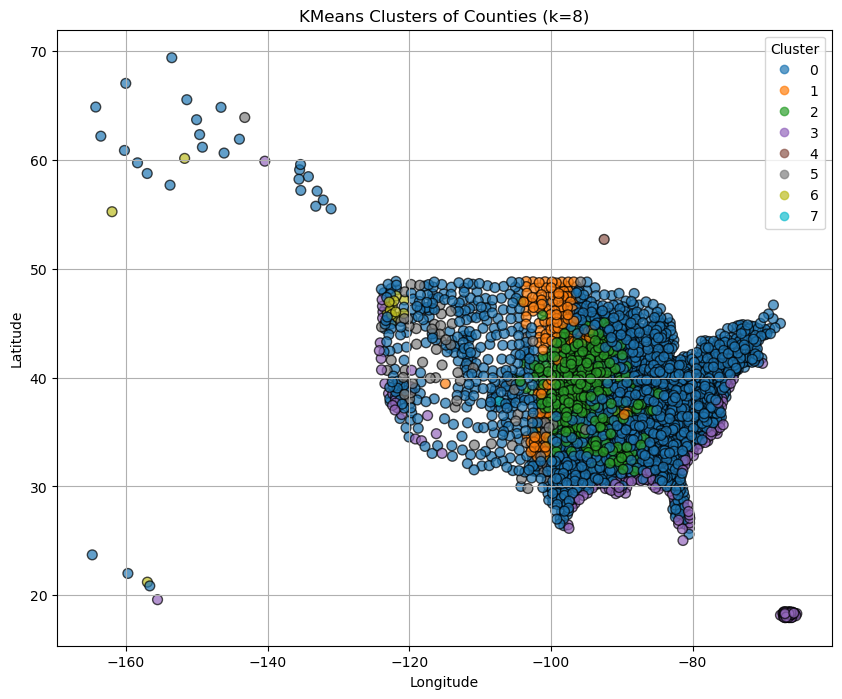

Silhouette Score: 0.316


In [30]:
# K means clustering with k=8 has highest silhouette score
k_opt = 8

kmeans = KMeans(n_clusters=k_opt, n_init=10, random_state=1)
cluster_assign = kmeans.fit_predict(X_scaled)

cleaned_df1 = cleaned_df.copy()  
cleaned_df1['cluster'] = cluster_assign

n_clusters = cleaned_df1['cluster'].nunique()
colors = plt.cm.tab10(np.linspace(0, 1, n_clusters))   
cmap = ListedColormap(colors)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    cleaned_df1['lon'], 
    cleaned_df1['lat'], 
    c=cleaned_df1['cluster'], 
    cmap=cmap,   
    s=50, 
    alpha=0.7, 
    edgecolors='k'
)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("KMeans Clusters of Counties (k=8)")
plt.legend(*scatter.legend_elements(), title="Cluster", loc="best")
plt.grid(True)
plt.show()

sil_score = silhouette_score(X_scaled, cluster_assign)
print(f"Silhouette Score: {sil_score:.3f}")

The K-Means clustering (k=8) shows clear geographic clusters of counties based on the expected annual loss rate for buildings due to 17 different climate hazards. The purple on the coasts is likely correlated with coastal flooding, hurricanes, whereas the centrally-located green likely is a cluster of counties susceptible to tornadoes. 

## DBSCAN Clustering

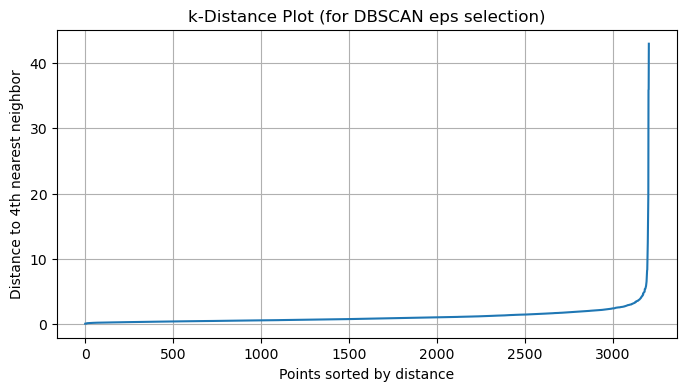

In [31]:
# K-distance plot to find eps for DBSCAN
k = 4
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

k_distances = np.sort(distances[:, k-1])

plt.figure(figsize=(8, 4))
plt.plot(k_distances)
plt.ylabel(f"Distance to {k}th nearest neighbor")
plt.xlabel("Points sorted by distance")
plt.title("k-Distance Plot (for DBSCAN eps selection)")
plt.grid(True)
plt.show()

Estimated number of clusters: 1
Estimated number of noise points: 9
Silhouette Coefficient: 0.852


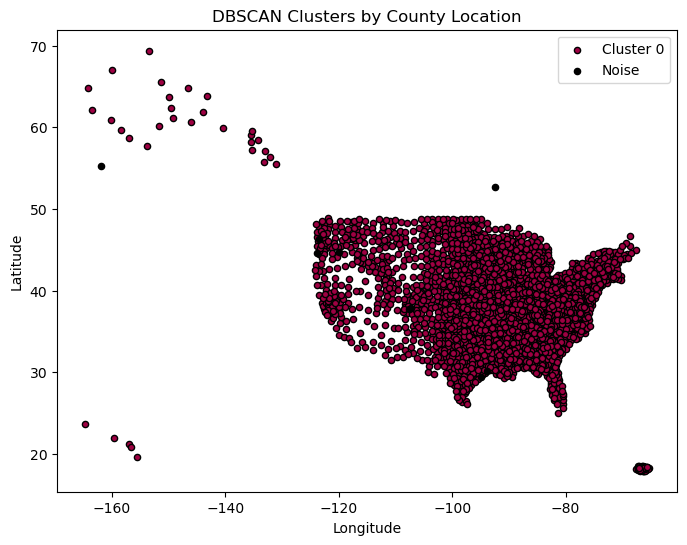

In [32]:
# DBSCAN Clustering with eps=7, min_pts=5
db = DBSCAN(eps=7, min_samples=5).fit(X_scaled)
labels = db.labels_

core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print(f"Estimated number of clusters: {n_clusters_}")
print(f"Estimated number of noise points: {n_noise_}")
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X_scaled, labels))

cleaned_df["dbscan_cluster"] = np.nan
cleaned_df.loc[cleaned_df.index, "dbscan_cluster"] = labels

plt.figure(figsize=(8, 6))
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 1]  # Black for noise
    class_mask = (labels == k)
    plt.scatter(
        x=cleaned_df.loc[cleaned_df.index[class_mask], 'lon'],
        y=cleaned_df.loc[cleaned_df.index[class_mask], 'lat'],
        c=[tuple(col)],
        edgecolor='k',
        s=20,
        label=f"Cluster {k}" if k != -1 else "Noise"
    )

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("DBSCAN Clusters by County Location")
plt.legend()
plt.show()

Even though the DBSCAN silhouette score is much higher (0.85) than K-Means (0.32), DBSCAN only provided 1 cluster, making the score inflated. On the other hand, K-Means provides full coverage by drawing complete usable clusters across all counties. 

## Examining Clusters' Housing Vulnerability Profiles

        pct_units_pre1940 pct_overcrowded median_rent_pct_income pct_vacant_units pct_mobile_homes pct_lacking_plumbing median_year_built num_counties
                   median          median                 median           median           median               median            median             
cluster                                                                                                                                               
0                    9.78            1.80                  27.80            15.06             9.94                 3.17            1979.0         2160
1                   19.94            1.61                  23.40            19.20             6.78                 4.65            1967.5          156
2                   19.25            1.65                  25.40            16.26             6.68                 4.59            1972.0          585
3                    2.37            2.36                  30.15            19.21             

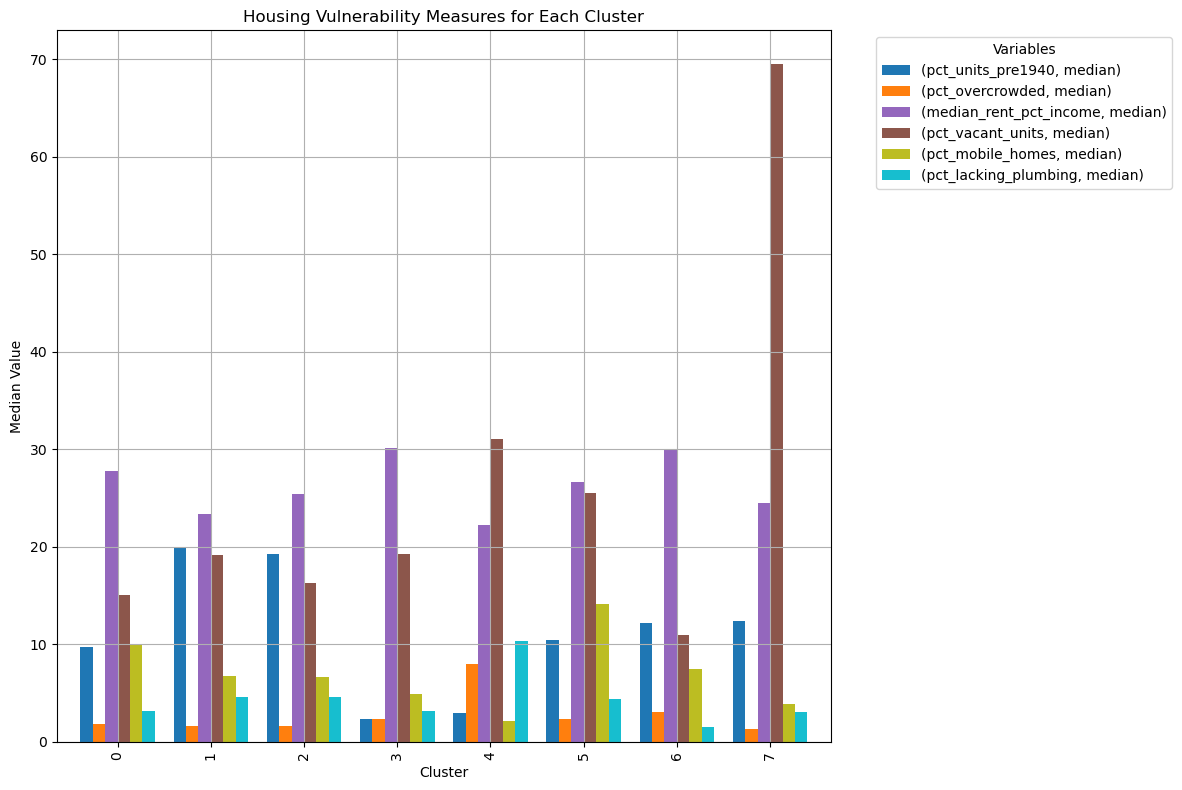

In [33]:
# Clusters' Summary Stats on Housing Vulnerability Features
cols = [
    'pct_units_pre1940',
    'pct_overcrowded',
    'median_rent_pct_income',
    'pct_vacant_units',
    'pct_mobile_homes',
    'pct_lacking_plumbing',
    'median_year_built'
]
summary_stats = cleaned_df1.groupby('cluster')[cols].agg(['median'])
cluster_counts = cleaned_df1['cluster'].value_counts()
summary_stats['num_counties'] = summary_stats.index.map(cluster_counts)

summary_df = pd.DataFrame(summary_stats.round(2))
print(summary_df.to_string(index=True, header=True))


summary_stats = summary_stats.drop(columns=['median_year_built', 'num_counties'])

fig, ax = plt.subplots(figsize=(12, 8))

summary_stats.plot(kind='bar', ax=ax, colormap=cmap, width=0.8)

ax.set_title('Housing Vulnerability Measures for Each Cluster')
ax.set_ylabel('Median Value')
ax.set_xlabel('Cluster')
ax.legend(title='Variables', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True)

plt.tight_layout()
plt.show()

In [35]:
# Two counties (4,7) are their own cluster -- Aleutians West Census Area, AK & Hinsdale County, CO
cluster_4_and_7 = cleaned_df1[cleaned_df1['cluster'].isin([4, 7])]
county_names = cluster_4_and_7['NAME']
print(county_names)

1693             Hinsdale County, Colorado
2389    Aleutians West Census Area, Alaska
Name: NAME, dtype: object


Note: Two counties (4,7) are their own cluster -- Aleutians West Census Area, AK & Hinsdale County, CO. I should have probably explained why these are 1-county clusters but I dont know...

### Risk Profile by Cluster and Hazard

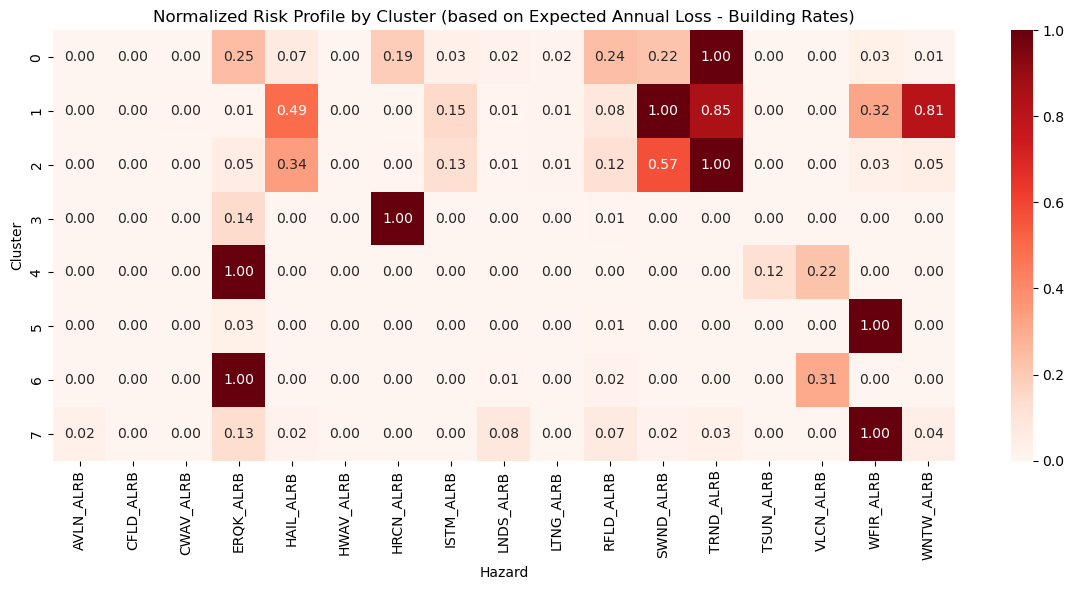

In [37]:
# Normalized Risk Profile by Cluster based on Expected Annual Loss - Building Rates for Hazards
alrb_cols = [col for col in cleaned_df1.columns if '_ALRB' in col]
risk_profile = cleaned_df1.groupby('cluster')[alrb_cols].median()
risk_profile_norm = risk_profile.div(risk_profile.max(axis=1), axis=0)
plt.figure(figsize=(12, 6))
sns.heatmap(risk_profile_norm, annot=True, cmap="Reds", fmt=".2f")
plt.title("Normalized Risk Profile by Cluster (based on Expected Annual Loss - Building Rates)")
plt.xlabel("Hazard")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()

According to the risk profiles for each cluster, Cluster 0 seems like the most general that covers nearly the entire eastern half of the country and is marked by low expected building value loss for earthquake, hurricane, severe wind, river flooding, and highest EAL for tornadoes. Its housing vulnerability measures are the standard. Cluster 1 is marked by moderately high risk for building damage due to hail, tornado, wildfire, winter weather, and highest risk for severe wind. Most counties in this cluster are in the middle/north. Its housing vulnerability measures are the standard. It has the highest % of units built before 1940 and the lowest median age of units. Cluster 2 is marked by moderately high risk for hail and severe wind and highest risk for tornado. Most counties in this cluster are in the middle land locked center of the country. Its housing vulnerability measures are the standard. It also has nearly the highest % of units built before 1940. Cluster 3 has relatively no risk for anything except a low amount for earthquake and the highest for hurricanes, which makes sense because these counties are only located on the west and southeast coasts of the country. It has an especially low % of units built before 1940 and the highest median rent as a % of income of all the clusters. Cluster 5 has basically no risk for anything except the highest for wildfires, which make sense because these counties are located just interior to the west coast in states like Nevada. It has particularly high rates of vacant units and mobile homes. Cluster 6 has relatively moderate, but the highest of all clusters, expected annual loss risk for volcanic activity and the highest risk for earthquakes. Almost all of its counties are located in Washington state in the northwest but also includes scattered counties in Hawaii and Alaska.


### Finding outliers by county

                              NAME  cluster        lat         lon
1622  Riverside County, California        0  33.743677 -115.993833
1269      Mineral County, Colorado        0  37.668996 -106.924095
1348     Island County, Washington        0  48.162897 -122.575263
1354    Clallam County, Washington        0  48.110292 -123.934214
1376        Douglas County, Oregon        0  43.285346 -123.179557


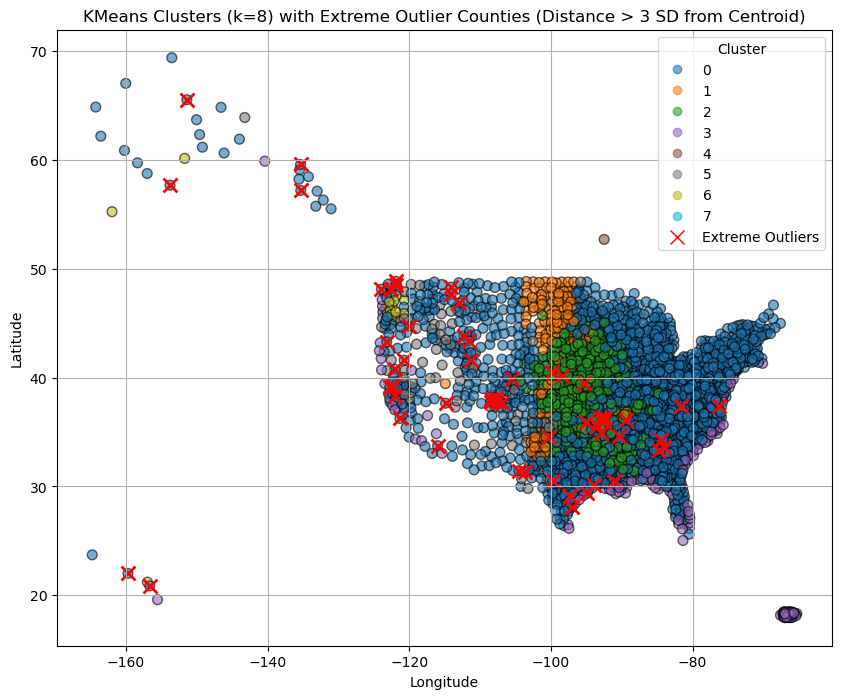

Number of counties that are outliers for their respective cluster: 58


In [38]:
# Find counties that are extreme outliers in their clusters (> 3 SD above cluster's avg dist to centroid)
centroids = kmeans.cluster_centers_
cluster_assign = cleaned_df1['cluster'].values  # or however you store cluster labels

X_scaled_array = X_scaled.to_numpy() if hasattr(X_scaled, "to_numpy") else X_scaled
distances = np.linalg.norm(X_scaled_array - centroids[cluster_assign], axis=1)

cleaned_df1['dist_to_centroid'] = distances

outliers_by_cluster = []

for c in cleaned_df1['cluster'].unique():
    cluster_data = cleaned_df1[cleaned_df1['cluster'] == c]
    mean_dist = cluster_data['dist_to_centroid'].mean()
    std_dist = cluster_data['dist_to_centroid'].std()
    threshold = mean_dist + 3 * std_dist

    cluster_outliers = cluster_data[cluster_data['dist_to_centroid'] > threshold][['NAME', 'cluster', 'lat', 'lon']]
    outliers_by_cluster.append(cluster_outliers)

extreme_outliers_grouped = pd.concat(outliers_by_cluster).sort_values(by='cluster')
print(extreme_outliers_grouped.head(5))

extreme_outliers_grouped.to_pickle('outliers.pkl')

plt.figure(figsize=(10, 8))

scatter = plt.scatter(
    cleaned_df1['lon'], 
    cleaned_df1['lat'], 
    c=cleaned_df1['cluster'], 
    cmap=cmap, 
    s=50, 
    alpha=0.6, 
    edgecolors='k'
)

plt.scatter(
    extreme_outliers_grouped['lon'], 
    extreme_outliers_grouped['lat'], 
    color='red', 
    marker='x', 
    s=100, 
    linewidths=2,
    label='Extreme Outliers'
)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("KMeans Clusters (k=8) with Extreme Outlier Counties (Distance > 3 SD from Centroid)")

handles, labels = scatter.legend_elements()
handles.append(plt.Line2D([0], [0], marker='x', color='red', linestyle='', markersize=10, label='Extreme Outliers'))
labels.append('Extreme Outliers')
plt.legend(handles, labels, title="Cluster", loc="best")

plt.grid(True)
plt.show()

num_outlier_counties = extreme_outliers_grouped['NAME'].nunique()
print(f"Number of counties that are outliers for their respective cluster: {num_outlier_counties}")

## Housing Vulnerability and Risk Hazard in Outlier Counties 
Find difference in housing vulnerabilty score and risks score between outlier counties and their cluster averages

In [39]:
# Take the average of housing fragility variables to create a fragility score for each county
cleaned_df2 = cleaned_df1.copy()

housing_vars = [
    'pct_units_pre1940',
    'pct_overcrowded',
    'median_rent_pct_income',
    'pct_vacant_units',
    'pct_mobile_homes',
    'pct_lacking_plumbing'
]

cleaned_df2['fragility_score'] = cleaned_df2[housing_vars].mean(axis=1)

In [41]:
# Compare outliers housing fragility score to the their cluster average score

alrb_columns = [col for col in cleaned_df2.columns if col.startswith("ALRB")]

outliers = extreme_outliers_grouped.merge(cleaned_df2[["NAME", "cluster"] + alrb_columns + ["fragility_score"]], 
                          on=["NAME", "cluster"], how="left")

cluster_means = cleaned_df2.groupby("cluster")[alrb_columns + ["fragility_score"]].mean().reset_index()

outliers_vs_cluster = outliers.merge(
    cluster_means,
    on="cluster",
    suffixes=("", "_cluster_avg")
)

for col in alrb_columns:
    outliers_vs_cluster[f"{col}_delta"] = (
        outliers_vs_cluster[col] - outliers_vs_cluster[f"{col}_cluster_avg"]
    )
outliers_vs_cluster["fragility_delta"] = (
    outliers_vs_cluster["fragility_score"] - outliers_vs_cluster["fragility_score_cluster_avg"]
)

high_risk_outliers = outliers_vs_cluster[["NAME", "cluster", "fragility_delta"] + [f"{col}_delta" for col in alrb_columns]]


/var/folders/vd/kxtbrgs50mx5h4q6mzczwdgc0000gn/T/ipykernel_46114/3201983029.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


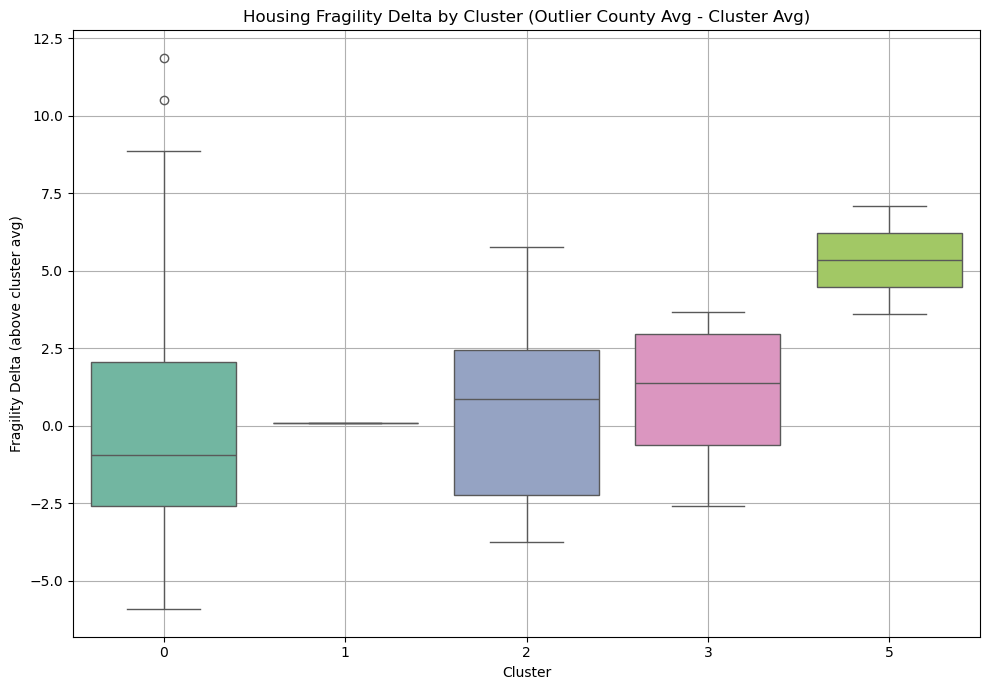

In [42]:
# Housing Fragility Delta Box plot by Cluster (outliers vs cluster)
# Difference between indv county's housing fragility & their cluster average housing fragility

plt.figure(figsize=(10, 7))
sns.boxplot(
    x='cluster', 
    y='fragility_delta', 
    data=outliers_vs_cluster, 
    palette='Set2'
)
plt.title("Housing Fragility Delta by Cluster (Outlier County Avg - Cluster Avg)")
plt.xlabel("Cluster")
plt.ylabel("Fragility Delta (above cluster avg)")
plt.grid(True)
plt.tight_layout()
plt.show()

Each boxplot represents the difference in housing fragility score between the overall cluster and the outliers in that cluster. As we can see, only the outliers in cluster 5 have a higher fragility score than the average county in cluster 5. In addition, there are notably two outliers in county 0 that have fragility scores 3 standard deviations above the mean fragility score for counties in cluster 0.  

In [43]:
# Compute hazard score for each county by summing hazards EAL & compute average hazard_score by cluster 
# Hazard_delta: difference between indv county's hazard score & their cluster average hazard score

from sklearn.preprocessing import StandardScaler

alrb_columns = [col for col in cleaned_df2.columns if col.endswith("ALRB")]
if not alrb_columns:
    raise ValueError("No ALRB columns found in cleaned_df2")

scaler = StandardScaler()
cleaned_df2_norm = cleaned_df2.copy()

if cleaned_df2[alrb_columns].isnull().values.any():
    raise ValueError("ALRB columns contain NaNs. Please handle missing values before standardizing.")

cleaned_df2_norm[alrb_columns] = scaler.fit_transform(cleaned_df2[alrb_columns])

cleaned_df2_norm["hazard_score"] = cleaned_df2_norm[alrb_columns].sum(axis=1)

cluster_hazard_avg = cleaned_df2_norm.groupby("cluster")["hazard_score"].mean().reset_index()
cluster_hazard_avg.rename(columns={"hazard_score": "hazard_score_cluster_avg"}, inplace=True)

outliers = outliers.merge(
    cleaned_df2_norm[["NAME", "cluster", "hazard_score"]],
    on=["NAME", "cluster"],
    how="left"
)

outliers = outliers.merge(
    cluster_hazard_avg,
    on="cluster",
    how="left"
)
outliers["hazard_delta_score"] = outliers["hazard_score"] - outliers["hazard_score_cluster_avg"]

# Merge fragility score with hazard score columns for outliers by cluster 
outliers_merged = outliers.merge(outliers_vs_cluster[["NAME", "fragility_score_cluster_avg", "fragility_delta"]],
                                on="NAME", how="left")

fragility_columns = ['fragility_score', 'fragility_score_cluster_avg', 'fragility_delta']
hazard_columns = ['hazard_score', 'hazard_score_cluster_avg', 'hazard_delta_score']

all_columns = outliers_merged.columns.tolist()
other_columns = [col for col in all_columns if col not in fragility_columns and col not in hazard_columns]
ordered_fragility_hazard = fragility_columns + hazard_columns
new_column_order = other_columns + ordered_fragility_hazard
outliers_merged = outliers_merged[new_column_order]

/var/folders/vd/kxtbrgs50mx5h4q6mzczwdgc0000gn/T/ipykernel_46114/3524548317.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="cluster", y="hazard_delta_score", data=outliers_merged, palette="Set2")


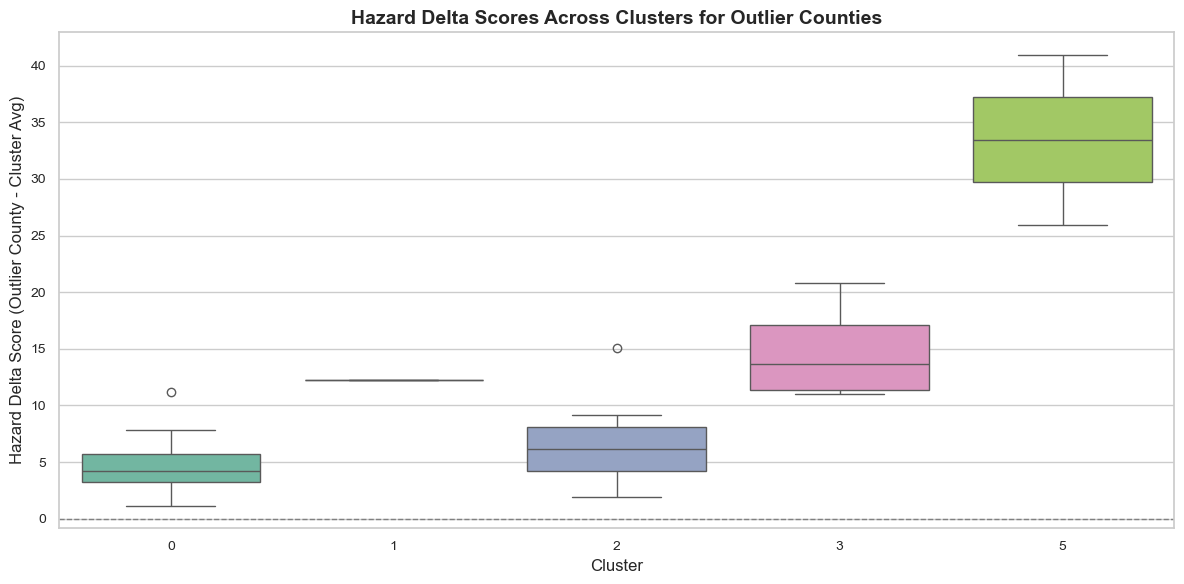

                         NAME  cluster        lat         lon  \
56  San Juan County, Colorado        5  37.764043 -107.676147   
57     Wheeler County, Oregon        5  44.726119 -120.027566   

    fragility_score  fragility_score_cluster_avg  fragility_delta  \
56        22.217341                    15.116947         7.100393   
57        18.708746                    15.116947         3.591799   

    hazard_score  hazard_score_cluster_avg  hazard_delta_score  
56     31.230476                  5.265345           25.965131  
57     46.208672                  5.265345           40.943327  


In [44]:
# Boxplot of Hazard Delta (Outlier County Avg - Cluster Avg) 
sns.set_theme(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.boxplot(x="cluster", y="hazard_delta_score", data=outliers_merged, palette="Set2")

plt.title("Hazard Delta Scores Across Clusters for Outlier Counties", fontsize=14, weight='bold')
plt.xlabel("Cluster", fontsize=12)
plt.ylabel("Hazard Delta Score (Outlier County - Cluster Avg)", fontsize=12)
plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

cluster_5_outliers = outliers_merged[outliers_merged['cluster'] == 5]
print(cluster_5_outliers)

Each boxplot represents the difference in composite hazard EAL building score (calculating by normalizing EAL Building Rates by column and summing them) between the overall cluster and the outliers in that cluster. As we can see, outliers in all clusters have a higher hazard score than the average county in their cluster. Again, cluster 5 shows the greatest difference betweeen the two outliars for that cluster and the cluster. So generally, the outliars in each cluster face a lot more expected loss to buildings than the average county in their cluster. 

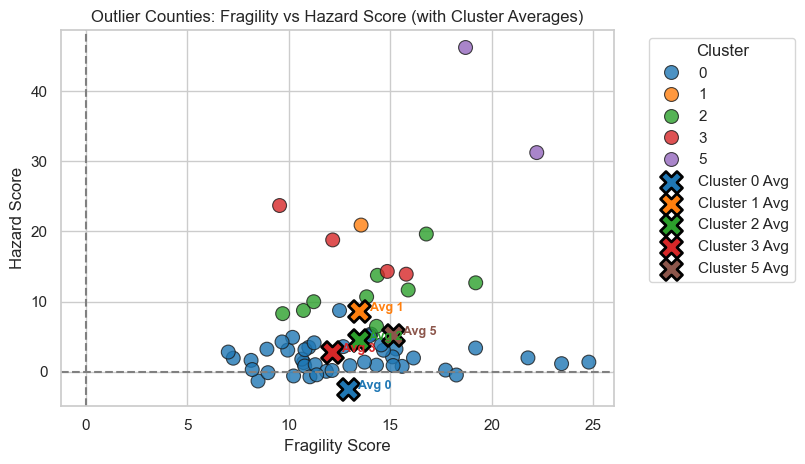

In [45]:
# Plotting outlier counties hazard & fragility score with cluster averages to see distance

sns.scatterplot(
    data=outliers_merged,
    x="fragility_score",
    y="hazard_score",
    hue="cluster",
    palette="tab10",
    s=100,
    edgecolor="k",
    alpha=0.8,
    legend="full"
)

cluster_avgs = outliers_merged.groupby("cluster")[
    ["fragility_score_cluster_avg", "hazard_score_cluster_avg"]
].mean().reset_index()

for i, row in cluster_avgs.iterrows():
    plt.scatter(
        row["fragility_score_cluster_avg"],
        row["hazard_score_cluster_avg"],
        marker="X",
        s=250,
        color=sns.color_palette("tab10")[int(row["cluster"])],
        edgecolor="black",
        linewidth=2,
        label=f"Cluster {int(row['cluster'])} Avg"
    )
    plt.text(
        row["fragility_score_cluster_avg"] + 0.5,
        row["hazard_score_cluster_avg"],
        f"Avg {int(row['cluster'])}",
        fontsize=9,
        weight="bold",
        color=sns.color_palette("tab10")[int(row["cluster"])]
    )

plt.xlabel("Fragility Score")
plt.ylabel("Hazard Score")
plt.title("Outlier Counties: Fragility vs Hazard Score (with Cluster Averages)")
plt.axhline(0, linestyle="--", color="gray")
plt.axvline(0, linestyle="--", color="gray")
plt.grid(True)
plt.tight_layout()
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


It seems that compared to the average fragility and hazard score by cluster, outliers in those clusters tend to score higher on both hazard and risk compared to non-outlier counties in those clusters. 

## Validation-- are clusters and outliers just noise?

#### Compare to dumb but reasonable approach to see if outliers by cluster we obtained by clustering are the same from finding top counties by hazard score and by housing vulnerability score

In [46]:
# Compare dumb-but-reasonable approach of finding counties with highest composite hazard score and highest fragility score

alrb_columns = [col for col in cleaned_df2.columns if col.endswith("ALRB")]
scaler = StandardScaler()
cleaned_df2_scaled = cleaned_df2.copy()
cleaned_df2_scaled[alrb_columns] = scaler.fit_transform(cleaned_df2[alrb_columns])
cleaned_df2_scaled["hazard_score"] = cleaned_df2_scaled[alrb_columns].sum(axis=1)

top_by_hazard = cleaned_df2_scaled.sort_values("hazard_score", ascending=False).head(58)
top_by_fragility = cleaned_df2_scaled.sort_values("fragility_score", ascending=False).head(58)

cleaned_df2_scaled["combined_score"] = (
    cleaned_df2_scaled["hazard_score"] + cleaned_df2_scaled["fragility_score"]
)
top_by_combined = cleaned_df2_scaled.sort_values("combined_score", ascending=False).head(58)

outlier_names = set(outliers["NAME"])

# Check overlap
hazard_overlap = set(top_by_hazard["NAME"]) & outlier_names
fragility_overlap = set(top_by_fragility["NAME"]) & outlier_names
combined_overlap = set(top_by_combined["NAME"]) & outlier_names

print(f"Hazard overlap: {len(hazard_overlap)}")
print(f"Fragility overlap: {len(fragility_overlap)}")
print(f"Combined overlap: {len(combined_overlap)}")


Hazard overlap: 7
Fragility overlap: 4
Combined overlap: 9


Low overlap suggests that clustering helps finds counties that are unusual within (likely geographic/hazard-based) clusters, but not necessarily the worst globally and is better for relative analysis.

### Cross Validation

In [52]:
# 5-fold cross-validation & Siloutte Score Metric
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import silhouette_score

alrb_columns = [col for col in cleaned_df2.columns if '_ALRB' in col]
X = cleaned_df2[alrb_columns]   

kmeans = KMeans(n_clusters=8, random_state=1)   

kf = KFold(n_splits=5, shuffle=True, random_state=42)

def silhouette_cv_score(X, model, cv):
    silhouette_scores = []
    for train_idx, test_idx in cv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        model.fit(X_train)
        y_pred = model.predict(X_test)
        score = silhouette_score(X_test, y_pred)
        silhouette_scores.append(score)
    return silhouette_scores

silhouette_scores = silhouette_cv_score(X, kmeans, kf)
cv_scores = cross_val_score(kmeans, X, cv=kf)

print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV score: {cv_scores.mean()}")
print(f"Standard deviation of CV score: {cv_scores.std()}")
print(f"Silhouette scores: {silhouette_scores}")
print(f"Mean silhouette score: {np.mean(silhouette_scores)}")
print(f"Standard deviation of silhouette score: {np.std(silhouette_scores)}")


Cross-validation scores: [-8.88857751e-05 -1.91607859e-04 -1.00708377e-04 -1.11406985e-04
 -1.27398201e-04]
Mean CV score: -0.00012400143956995262
Standard deviation of CV score: 3.6101143588601714e-05
Silhouette scores: [0.523463361717852, 0.528330642488309, 0.553520597226998, 0.5196253702103181, 0.5906241591747774]
Mean silhouette score: 0.5431128261636509
Standard deviation of silhouette score: 0.02654024663555037


The silhouette scores of around 0.52 to 0.59 suggest that  the clusters are somewhat well-separated. 

#### Examine the two outlier counties in cluster 5 that are significantly higher in risk and hazard scores from the cluster average

- San Juan County, CO
According to https://www.deirdredenaliphotography.com/blog/drought-and-wildfires-in-the-san-juan-mountains, San Juan County, Colorado is known for both its history of avalanches as well as more recent wildfire and drought. 
 
- Wheeler County, Oregon has a very large disparity between its hazard score (46.2) and the average for its cluster (2.3) but doesn't turn up any notable search results about natural disasters there. 



In [ ]:
print(outliers_merged[outliers_merged['cluster'] == 5])

                         NAME  cluster        lat         lon  \
56  San Juan County, Colorado        5  37.764043 -107.676147   
57     Wheeler County, Oregon        5  44.726119 -120.027566   

    fragility_score  fragility_score_cluster_avg  fragility_delta  \
56        22.217341                    15.116947         7.100393   
57        18.708746                    15.116947         3.591799   

    hazard_score  hazard_score_cluster_avg  hazard_delta_score  
56     31.230476                  5.265345           25.965131  
57     46.208672                  5.265345           40.943327  
                                                     227
STCOFIPS                                            8111
lat                                            37.764043
lon                                          -107.676147
STATEABBRV                                            CO
BUILDVALUE                                   353411005.0
AREA                                          392.221674
AV

## Risks and Limitations
One risk of this data is that it is a 2022 snapshot of hazard risk and every year could be different, and the model lacks "year" as a control. Another limitation of this approach is that k-means requires a pre-determined k, and even though we used an elbow plot to determine k, other clustering methods like DBSCAN chose only 2 clusters and had higher silhoutte scores. Another limitation is that we don't have a full understanding of why outlier counties are outliers in their clusters other than they tend to have higher composite risk. It would be useful to break down which hazards they have higher risk for to develop a more precise understanding of the hazard risk they face, as well as what housing features they are particularly weak in. This would help tailor recommendations to emergency planning agencies that could implement county-specific solutions to problems that make them doubly-vulnerable to various climate disasters, and prevent anomaly counties from slipping through the cracks. 

## Conclusion
When clustering counties based on their Expected Annual Loss to Buildings, the primary clusters take shape based on geographic location and thus the type of hazards that are most common there, for example wildfire risk on in the western mountain states and coastal flooding on California's coast. However, within these clusters are counties that share similar risk patterns but are extreme outliers. These outliers, espeically those in cluster 5, geographically located in Nevada/Utah, most susceptible to wildfire, high rates of vacant units and mobile homes, are particularly at heightened hazard risk and have higher housing vulnerability compared to other counties in that cluster. Thus, these could be counties that are at risk of falling through the cracks by virtue of them being clustered with geographically similar counties and them being doubly vulnerable due to housing factors. Counties like these could lack clear recommendation for how they should be climate proofing their communities because they are hidden in other patterns, yet they are particularly threatened by climate change. 
